In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3
env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [2]:
import os
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
structures = pd.read_pickle("datasets/structures_defects.pickle.gzip")

In [4]:
# TODO(inner perfectionist) eval is unsecure
defects = pd.read_csv(
  "datasets/dichalcogenides_innopolis_202105/descriptors.csv", index_col="_id",
  converters={"cell": eval, "defects": eval})

In [5]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.utils.preprocessing import StandardScaler
from megnet.callbacks import ModelCheckpointMAE
from pymatgen.core import Lattice, Structure, Molecule

import tensorflow as tf
import numpy as np

In [6]:
import wandb
from wandb.keras import WandbCallback

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# TODO(kazeevn) pass structure as the global state
train, test = train_test_split(structures, test_size=0.25, random_state=42)

In [9]:
wandb.init(project='ai4material_design', entity='kazeev')

wandb: Currently logged in as: kazeev (use `wandb login --relogin` to force relogin)


In [10]:
config = wandb.config
config.target = "energy_per_atom"

In [11]:
from typing import Union, List, Dict
from megnet.data.graph import StructureGraphFixedRadius
from pymatgen.analysis.local_env import NearNeighbors
from megnet.data.graph import Converter
class ZAwareStrucutreGraph(StructureGraphFixedRadius):
    def __init__(
        self,
        nn_strategy: Union[str, NearNeighbors] = "MinimumDistanceNNAll",
        atom_converter: Converter = None,
        bond_converter: Converter = None,
        cutoff: float = 5.0,
    ):
      raise NotImplemented("Doesn't work due to difficult estate planning")
      self.cutoff = cutoff
      super().__init__(
              nn_strategy=nn_strategy, atom_converter=atom_converter, bond_converter=bond_converter, cutoff=self.cutoff
      )
        
      @staticmethod
      def get_atom_features(structure):
        return [[i.species.Z, i.coords[2]] for i in structure.sites]

In [12]:
nfeat_edge = 10
gc = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 15, nfeat_edge), 0.5),
                  cutoff=15)
model = MEGNetModel(nfeat_edge=nfeat_edge, nfeat_global=2, graph_converter=gc, npass=2)

In [13]:
scaler = StandardScaler.from_training_data(train.defect_representation,
                                           train[config.target], is_intensive=True)
model.target_scaler = scaler

In [14]:
model.train(train.defect_representation, train[config.target],
            validation_structures=test.defect_representation,
            validation_targets=test[config.target],
            callbacks=[WandbCallback()],
            epochs=2000, verbose=1, patience=1000)

Epoch 1/2000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/set2set_atom/Reshape_9:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/set2set_atom/Reshape_8:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/model/set2set_atom/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/set2set_bond/Reshape_9:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/set2set_bond/Reshape_8:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/model/set2set_bond/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of m

21/21 [==============================] - 19s 86ms/step - loss: 4.6172


INFO:megnet.callbacks:
Epoch 00001: val_mae improved from inf to 0.11847, saving model to callback/val_mae_00001_0.118465.hdf5


Epoch 2/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.1247


INFO:megnet.callbacks:
Epoch 00002: val_mae improved from 0.11847 to 0.04393, saving model to callback/val_mae_00002_0.043931.hdf5


Epoch 3/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0646


INFO:megnet.callbacks:
Epoch 00003: val_mae improved from 0.04393 to 0.04011, saving model to callback/val_mae_00003_0.040111.hdf5


Epoch 4/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0460
Epoch 5/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0547


INFO:megnet.callbacks:
Epoch 00005: val_mae improved from 0.04011 to 0.03943, saving model to callback/val_mae_00005_0.039427.hdf5


Epoch 6/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0435
Epoch 7/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0497


INFO:megnet.callbacks:
Epoch 00007: val_mae improved from 0.03943 to 0.03472, saving model to callback/val_mae_00007_0.034719.hdf5


Epoch 8/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0404
Epoch 9/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0417


INFO:megnet.callbacks:
Epoch 00009: val_mae improved from 0.03472 to 0.03445, saving model to callback/val_mae_00009_0.034449.hdf5


Epoch 10/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0560
Epoch 11/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0480
Epoch 12/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0624
Epoch 13/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0361
Epoch 14/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0573
Epoch 15/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0372
Epoch 16/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0402
Epoch 17/2000
21/21 [==============================] - 2s 83ms/step - loss: 0.0545
Epoch 18/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0477
Epoch 19/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0405
Epoch 20/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0368
Epoch 21/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0474


INFO:megnet.callbacks:
Epoch 00021: val_mae improved from 0.03445 to 0.03358, saving model to callback/val_mae_00021_0.033584.hdf5


Epoch 22/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0440
Epoch 23/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0504
Epoch 24/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0390
Epoch 25/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0558
Epoch 26/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0700


INFO:megnet.callbacks:
Epoch 00026: val_mae improved from 0.03358 to 0.03352, saving model to callback/val_mae_00026_0.033522.hdf5


Epoch 27/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0583


INFO:megnet.callbacks:
Epoch 00027: val_mae improved from 0.03352 to 0.03345, saving model to callback/val_mae_00027_0.033451.hdf5


Epoch 28/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0277


INFO:megnet.callbacks:
Epoch 00028: val_mae improved from 0.03345 to 0.03332, saving model to callback/val_mae_00028_0.033316.hdf5


Epoch 29/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0523
Epoch 30/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0618
Epoch 31/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0530
Epoch 32/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0315
Epoch 33/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0402
Epoch 34/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0475
Epoch 35/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0459
Epoch 36/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0282
Epoch 37/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0557
Epoch 38/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0460
Epoch 39/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0528
Epoch 40/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0457
Epoc

INFO:megnet.callbacks:
Epoch 00061: val_mae improved from 0.03332 to 0.03326, saving model to callback/val_mae_00061_0.033257.hdf5


Epoch 62/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0468
Epoch 63/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0480
Epoch 64/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0410
Epoch 65/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0431
Epoch 66/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0407
Epoch 67/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0453
Epoch 68/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0439
Epoch 69/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0327


INFO:megnet.callbacks:
Epoch 00069: val_mae improved from 0.03326 to 0.03311, saving model to callback/val_mae_00069_0.033112.hdf5


Epoch 70/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0318
Epoch 71/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0278
Epoch 72/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0364
Epoch 73/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0361
Epoch 74/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0503
Epoch 75/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0404
Epoch 76/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0394


INFO:megnet.callbacks:
Epoch 00076: val_mae improved from 0.03311 to 0.03257, saving model to callback/val_mae_00076_0.032570.hdf5


Epoch 77/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0482
Epoch 78/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0451
Epoch 79/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0563
Epoch 80/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0344
Epoch 81/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0510
Epoch 82/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0498
Epoch 83/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0406
Epoch 84/2000
21/21 [==============================] - 2s 89ms/step - loss: 0.0294
Epoch 85/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0431
Epoch 86/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0329


INFO:megnet.callbacks:
Epoch 00086: val_mae improved from 0.03257 to 0.03228, saving model to callback/val_mae_00086_0.032282.hdf5


Epoch 87/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0443


INFO:megnet.callbacks:
Epoch 00087: val_mae improved from 0.03228 to 0.03135, saving model to callback/val_mae_00087_0.031347.hdf5


Epoch 88/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0444
Epoch 89/2000
21/21 [==============================] - 2s 90ms/step - loss: 0.0374


INFO:megnet.callbacks:
Epoch 00089: val_mae improved from 0.03135 to 0.03055, saving model to callback/val_mae_00089_0.030548.hdf5


Epoch 90/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0421
Epoch 91/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0465
Epoch 92/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0469
Epoch 93/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0283
Epoch 94/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0243
Epoch 95/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0398
Epoch 96/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0359
Epoch 97/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0427
Epoch 98/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0303
Epoch 99/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0316
Epoch 100/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0505
Epoch 101/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0368
Ep

INFO:megnet.callbacks:
Epoch 00102: val_mae improved from 0.03055 to 0.03048, saving model to callback/val_mae_00102_0.030482.hdf5


Epoch 103/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0359
Epoch 104/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0362
Epoch 105/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0349
Epoch 106/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0249


INFO:megnet.callbacks:
Epoch 00106: val_mae improved from 0.03048 to 0.03011, saving model to callback/val_mae_00106_0.030112.hdf5


Epoch 107/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0385
Epoch 108/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0281
Epoch 109/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0291
Epoch 110/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0339
Epoch 111/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0422
Epoch 112/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0344
Epoch 113/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0339
Epoch 114/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0301
Epoch 115/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0362
Epoch 116/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0349
Epoch 117/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0360
Epoch 118/2000
21/21 [==============================] - 2s 85ms/step - loss:

INFO:megnet.callbacks:
Epoch 00122: val_mae improved from 0.03011 to 0.03003, saving model to callback/val_mae_00122_0.030027.hdf5


Epoch 123/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0343


INFO:megnet.callbacks:
Epoch 00123: val_mae improved from 0.03003 to 0.02874, saving model to callback/val_mae_00123_0.028741.hdf5


Epoch 124/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0280
Epoch 125/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0389
Epoch 126/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0364
Epoch 127/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0291
Epoch 128/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0307
Epoch 129/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0409
Epoch 130/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0390
Epoch 131/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0477
Epoch 132/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0420
Epoch 133/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0412
Epoch 134/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0308
Epoch 135/2000
21/21 [==============================] - 2s 85ms/step - loss:

INFO:megnet.callbacks:
Epoch 00138: val_mae improved from 0.02874 to 0.02872, saving model to callback/val_mae_00138_0.028725.hdf5


Epoch 139/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0198
Epoch 140/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0357
Epoch 141/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0321
Epoch 142/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0408
Epoch 143/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0390
Epoch 144/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0438
Epoch 145/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0404
Epoch 146/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0499
Epoch 147/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0452
Epoch 148/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0311
Epoch 149/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0373
Epoch 150/2000
21/21 [==============================] - 2s 85ms/step - loss:

INFO:megnet.callbacks:
Epoch 00182: val_mae improved from 0.02872 to 0.02819, saving model to callback/val_mae_00182_0.028194.hdf5


Epoch 183/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0311


INFO:megnet.callbacks:
Epoch 00183: val_mae improved from 0.02819 to 0.02793, saving model to callback/val_mae_00183_0.027929.hdf5


Epoch 184/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0276
Epoch 185/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0338
Epoch 186/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0287
Epoch 187/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0473
Epoch 188/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0337
Epoch 189/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0304
Epoch 190/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0344
Epoch 191/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0260
Epoch 192/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0357
Epoch 193/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0384
Epoch 194/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0314
Epoch 195/2000
21/21 [==============================] - 2s 86ms/step - loss:

INFO:megnet.callbacks:
Epoch 00248: val_mae improved from 0.02793 to 0.02788, saving model to callback/val_mae_00248_0.027883.hdf5


Epoch 249/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0252
Epoch 250/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0284


INFO:megnet.callbacks:
Epoch 00250: val_mae improved from 0.02788 to 0.02733, saving model to callback/val_mae_00250_0.027327.hdf5


Epoch 251/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0205
Epoch 252/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0282
Epoch 253/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0293
Epoch 254/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0267
Epoch 255/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0231
Epoch 256/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0124
Epoch 257/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0222


INFO:megnet.callbacks:
Epoch 00257: val_mae improved from 0.02733 to 0.02717, saving model to callback/val_mae_00257_0.027167.hdf5


Epoch 258/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0222
Epoch 259/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0222
Epoch 260/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0315
Epoch 261/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0251
Epoch 262/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0233
Epoch 263/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0162
Epoch 264/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0143


INFO:megnet.callbacks:
Epoch 00264: val_mae improved from 0.02717 to 0.02657, saving model to callback/val_mae_00264_0.026567.hdf5


Epoch 265/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0163


INFO:megnet.callbacks:
Epoch 00265: val_mae improved from 0.02657 to 0.02650, saving model to callback/val_mae_00265_0.026504.hdf5


Epoch 266/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0304
Epoch 267/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0398
Epoch 268/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0247
Epoch 269/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0337
Epoch 270/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0318
Epoch 271/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0260
Epoch 272/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0269
Epoch 273/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0332
Epoch 274/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0201
Epoch 275/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0265
Epoch 276/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0248
Epoch 277/2000
21/21 [==============================] - 2s 85ms/step - loss:

INFO:megnet.callbacks:
Epoch 00278: val_mae improved from 0.02650 to 0.02646, saving model to callback/val_mae_00278_0.026464.hdf5


Epoch 279/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0165
Epoch 280/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0317
Epoch 281/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0227
Epoch 282/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0251
Epoch 283/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0184
Epoch 284/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0168
Epoch 285/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0223
Epoch 286/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0204
Epoch 287/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0215
Epoch 288/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0172
Epoch 289/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0266
Epoch 290/2000
21/21 [==============================] - 2s 85ms/step - loss:

INFO:megnet.callbacks:
Epoch 00295: val_mae improved from 0.02646 to 0.02627, saving model to callback/val_mae_00295_0.026270.hdf5


Epoch 296/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0194


INFO:megnet.callbacks:
Epoch 00296: val_mae improved from 0.02627 to 0.02404, saving model to callback/val_mae_00296_0.024042.hdf5


Epoch 297/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0132
Epoch 298/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0209
Epoch 299/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0249
Epoch 300/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0197
Epoch 301/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0321
Epoch 302/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0355
Epoch 303/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0237
Epoch 304/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0228
Epoch 305/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0275
Epoch 306/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0264
Epoch 307/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0144
Epoch 308/2000
21/21 [==============================] - 2s 87ms/step - loss:

INFO:megnet.callbacks:
Epoch 00322: val_mae improved from 0.02404 to 0.02403, saving model to callback/val_mae_00322_0.024032.hdf5


Epoch 323/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0125
Epoch 324/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0133
Epoch 325/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0123
Epoch 326/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0113
Epoch 327/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0319
Epoch 328/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0198
Epoch 329/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0128
Epoch 330/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0217
Epoch 331/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0249
Epoch 332/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0286
Epoch 333/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0175
Epoch 334/2000
21/21 [==============================] - 2s 86ms/step - loss:

INFO:megnet.callbacks:
Epoch 00335: val_mae improved from 0.02403 to 0.02386, saving model to callback/val_mae_00335_0.023856.hdf5


Epoch 336/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0203
Epoch 337/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0198
Epoch 338/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0141
Epoch 339/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0163
Epoch 340/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0121


INFO:megnet.callbacks:
Epoch 00340: val_mae improved from 0.02386 to 0.02362, saving model to callback/val_mae_00340_0.023619.hdf5


Epoch 341/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0135
Epoch 342/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0162
Epoch 343/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0096
Epoch 344/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0175
Epoch 345/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0142
Epoch 346/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0163


INFO:megnet.callbacks:
Epoch 00346: val_mae improved from 0.02362 to 0.02348, saving model to callback/val_mae_00346_0.023477.hdf5


Epoch 347/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0159
Epoch 348/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0114
Epoch 349/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0119
Epoch 350/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0138
Epoch 351/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0090
Epoch 352/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0121
Epoch 353/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0263
Epoch 354/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0132
Epoch 355/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0136
Epoch 356/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0138
Epoch 357/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0106
Epoch 358/2000
21/21 [==============================] - 2s 86ms/step - loss:

INFO:megnet.callbacks:
Epoch 00359: val_mae improved from 0.02348 to 0.02334, saving model to callback/val_mae_00359_0.023341.hdf5


Epoch 360/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0120
Epoch 361/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0092
Epoch 362/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0135
Epoch 363/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0170
Epoch 364/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0173
Epoch 365/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0271
Epoch 366/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0174
Epoch 367/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0279
Epoch 368/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0199
Epoch 369/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0154
Epoch 370/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0136
Epoch 371/2000
21/21 [==============================] - 2s 88ms/step - loss:

INFO:megnet.callbacks:
Epoch 00376: val_mae improved from 0.02334 to 0.02288, saving model to callback/val_mae_00376_0.022885.hdf5


Epoch 377/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0098
Epoch 378/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0345
Epoch 379/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0159
Epoch 380/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0088
Epoch 381/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0119
Epoch 382/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0112
Epoch 383/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0105
Epoch 384/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0075
Epoch 385/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0162
Epoch 386/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0098
Epoch 387/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0116
Epoch 388/2000
21/21 [==============================] - 2s 85ms/step - loss:

INFO:megnet.callbacks:
Epoch 00400: val_mae improved from 0.02288 to 0.02285, saving model to callback/val_mae_00400_0.022848.hdf5


Epoch 401/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0197
Epoch 402/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0169
Epoch 403/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0266
Epoch 404/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0218
Epoch 405/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0266
Epoch 406/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0179
Epoch 407/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0248
Epoch 408/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0144
Epoch 409/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0152
Epoch 410/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0233
Epoch 411/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0197
Epoch 412/2000
21/21 [==============================] - 2s 86ms/step - loss:

INFO:megnet.callbacks:
Epoch 00420: val_mae improved from 0.02285 to 0.02281, saving model to callback/val_mae_00420_0.022814.hdf5


Epoch 421/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0105
Epoch 422/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0089
Epoch 423/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0083
Epoch 424/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0108
Epoch 425/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0128
Epoch 426/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0080
Epoch 427/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0174
Epoch 428/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0114


INFO:megnet.callbacks:
Epoch 00428: val_mae improved from 0.02281 to 0.02281, saving model to callback/val_mae_00428_0.022810.hdf5


Epoch 429/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0163
Epoch 430/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0187
Epoch 431/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0091


INFO:megnet.callbacks:
Epoch 00431: val_mae improved from 0.02281 to 0.02255, saving model to callback/val_mae_00431_0.022554.hdf5


Epoch 432/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0089


INFO:megnet.callbacks:
Epoch 00432: val_mae improved from 0.02255 to 0.02247, saving model to callback/val_mae_00432_0.022465.hdf5


Epoch 433/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0080
Epoch 434/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0081
Epoch 435/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0110
Epoch 436/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0112


INFO:megnet.callbacks:
Epoch 00436: val_mae improved from 0.02247 to 0.02239, saving model to callback/val_mae_00436_0.022388.hdf5


Epoch 437/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0197


INFO:megnet.callbacks:
Epoch 00437: val_mae improved from 0.02239 to 0.02210, saving model to callback/val_mae_00437_0.022103.hdf5


Epoch 438/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0157
Epoch 439/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0071
Epoch 440/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0086
Epoch 441/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0096
Epoch 442/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0066


INFO:megnet.callbacks:
Epoch 00442: val_mae improved from 0.02210 to 0.02190, saving model to callback/val_mae_00442_0.021904.hdf5


Epoch 443/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0084
Epoch 444/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0061
Epoch 445/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0080
Epoch 446/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0141
Epoch 447/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0280
Epoch 448/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0255
Epoch 449/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0446
Epoch 450/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0301
Epoch 451/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0460
Epoch 452/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0321
Epoch 453/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0251
Epoch 454/2000
21/21 [==============================] - 2s 85ms/step - loss:

INFO:megnet.callbacks:
Epoch 00481: val_mae improved from 0.02190 to 0.02174, saving model to callback/val_mae_00481_0.021735.hdf5


Epoch 482/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0133


INFO:megnet.callbacks:
Epoch 00482: val_mae improved from 0.02174 to 0.02166, saving model to callback/val_mae_00482_0.021661.hdf5


Epoch 483/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0068
Epoch 484/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0052


INFO:megnet.callbacks:
Epoch 00484: val_mae improved from 0.02166 to 0.02123, saving model to callback/val_mae_00484_0.021230.hdf5


Epoch 485/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0093
Epoch 486/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0080
Epoch 487/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0086
Epoch 488/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0151
Epoch 489/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0103


INFO:megnet.callbacks:
Epoch 00489: val_mae improved from 0.02123 to 0.02118, saving model to callback/val_mae_00489_0.021185.hdf5


Epoch 490/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0048
Epoch 491/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0095
Epoch 492/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0134
Epoch 493/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0110
Epoch 494/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0255
Epoch 495/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0148
Epoch 496/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0099
Epoch 497/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0118
Epoch 498/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0121
Epoch 499/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0131
Epoch 500/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0087
Epoch 501/2000
21/21 [==============================] - 2s 86ms/step - loss:

INFO:megnet.callbacks:
Epoch 00504: val_mae improved from 0.02118 to 0.02072, saving model to callback/val_mae_00504_0.020718.hdf5


Epoch 505/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0065
Epoch 506/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0084


INFO:megnet.callbacks:
Epoch 00506: val_mae improved from 0.02072 to 0.02027, saving model to callback/val_mae_00506_0.020270.hdf5


Epoch 507/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0111
Epoch 508/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0081
Epoch 509/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0070
Epoch 510/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0098
Epoch 511/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0097
Epoch 512/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0130
Epoch 513/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0100
Epoch 514/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0095
Epoch 515/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0077
Epoch 516/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0109
Epoch 517/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0108
Epoch 518/2000
21/21 [==============================] - 2s 86ms/step - loss:

INFO:megnet.callbacks:
Epoch 00520: val_mae improved from 0.02027 to 0.02009, saving model to callback/val_mae_00520_0.020093.hdf5


Epoch 521/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0055
Epoch 522/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0088


INFO:megnet.callbacks:
Epoch 00522: val_mae improved from 0.02009 to 0.02008, saving model to callback/val_mae_00522_0.020075.hdf5


Epoch 523/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0050
Epoch 524/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0049
Epoch 525/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0077
Epoch 526/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0086
Epoch 527/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0059
Epoch 528/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0109
Epoch 529/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0069
Epoch 530/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0059
Epoch 531/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0197
Epoch 532/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0239
Epoch 533/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0293
Epoch 534/2000
21/21 [==============================] - 2s 88ms/step - loss:

INFO:megnet.callbacks:
Epoch 00582: val_mae improved from 0.02008 to 0.01995, saving model to callback/val_mae_00582_0.019952.hdf5


Epoch 583/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0067
Epoch 584/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0132
Epoch 585/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0149


INFO:megnet.callbacks:
Epoch 00585: val_mae improved from 0.01995 to 0.01982, saving model to callback/val_mae_00585_0.019818.hdf5


Epoch 586/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0058


INFO:megnet.callbacks:
Epoch 00586: val_mae improved from 0.01982 to 0.01938, saving model to callback/val_mae_00586_0.019378.hdf5


Epoch 587/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0122
Epoch 588/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0071
Epoch 589/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0113
Epoch 590/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0065
Epoch 591/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0060
Epoch 592/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0063
Epoch 593/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0067
Epoch 594/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0083
Epoch 595/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0065
Epoch 596/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0090
Epoch 597/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0110
Epoch 598/2000
21/21 [==============================] - 2s 86ms/step - loss:

INFO:megnet.callbacks:
Epoch 00635: val_mae improved from 0.01938 to 0.01910, saving model to callback/val_mae_00635_0.019101.hdf5


Epoch 636/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0049
Epoch 637/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0039
Epoch 638/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0046
Epoch 639/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0047


INFO:megnet.callbacks:
Epoch 00639: val_mae improved from 0.01910 to 0.01893, saving model to callback/val_mae_00639_0.018927.hdf5


Epoch 640/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0062


INFO:megnet.callbacks:
Epoch 00640: val_mae improved from 0.01893 to 0.01820, saving model to callback/val_mae_00640_0.018202.hdf5


Epoch 641/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0045


INFO:megnet.callbacks:
Epoch 00641: val_mae improved from 0.01820 to 0.01793, saving model to callback/val_mae_00641_0.017930.hdf5


Epoch 642/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0037
Epoch 643/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0032
Epoch 644/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0027
Epoch 645/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0029
Epoch 646/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0132
Epoch 647/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0051
Epoch 648/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0061
Epoch 649/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0047
Epoch 650/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0039
Epoch 651/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0090
Epoch 652/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0033
Epoch 653/2000
21/21 [==============================] - 2s 86ms/step - loss:

INFO:megnet.callbacks:
Epoch 00656: val_mae improved from 0.01793 to 0.01769, saving model to callback/val_mae_00656_0.017690.hdf5


Epoch 657/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0038
Epoch 658/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0025
Epoch 659/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0048
Epoch 660/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0041
Epoch 661/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0036


INFO:megnet.callbacks:
Epoch 00661: val_mae improved from 0.01769 to 0.01746, saving model to callback/val_mae_00661_0.017458.hdf5


Epoch 662/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0030


INFO:megnet.callbacks:
Epoch 00662: val_mae improved from 0.01746 to 0.01744, saving model to callback/val_mae_00662_0.017443.hdf5


Epoch 663/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0016


INFO:megnet.callbacks:
Epoch 00663: val_mae improved from 0.01744 to 0.01724, saving model to callback/val_mae_00663_0.017243.hdf5


Epoch 664/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0064


INFO:megnet.callbacks:
Epoch 00664: val_mae improved from 0.01724 to 0.01718, saving model to callback/val_mae_00664_0.017176.hdf5


Epoch 665/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0039


INFO:megnet.callbacks:
Epoch 00665: val_mae improved from 0.01718 to 0.01679, saving model to callback/val_mae_00665_0.016785.hdf5


Epoch 666/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0021
Epoch 667/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0017
Epoch 668/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0048
Epoch 669/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0015
Epoch 670/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0049
Epoch 671/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0027
Epoch 672/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0019
Epoch 673/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0015


INFO:megnet.callbacks:
Epoch 00673: val_mae improved from 0.01679 to 0.01663, saving model to callback/val_mae_00673_0.016633.hdf5


Epoch 674/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0048


INFO:megnet.callbacks:
Epoch 00674: val_mae improved from 0.01663 to 0.01638, saving model to callback/val_mae_00674_0.016378.hdf5


Epoch 675/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0026
Epoch 676/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0023
Epoch 677/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0043
Epoch 678/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0033
Epoch 679/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0021
Epoch 680/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0049
Epoch 681/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0041
Epoch 682/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0029
Epoch 683/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0023


INFO:megnet.callbacks:
Epoch 00683: val_mae improved from 0.01638 to 0.01627, saving model to callback/val_mae_00683_0.016273.hdf5


Epoch 684/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0040
Epoch 685/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0035
Epoch 686/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0052
Epoch 687/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0021
Epoch 688/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0030
Epoch 689/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0027


INFO:megnet.callbacks:
Epoch 00689: val_mae improved from 0.01627 to 0.01621, saving model to callback/val_mae_00689_0.016212.hdf5


Epoch 690/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0025
Epoch 691/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0035
Epoch 692/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0052
Epoch 693/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0067
Epoch 694/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0030
Epoch 695/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0025
Epoch 696/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0068
Epoch 697/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0025
Epoch 698/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0016
Epoch 699/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0011
Epoch 700/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0013
Epoch 701/2000
21/21 [==============================] - 2s 84ms/step - loss:

INFO:megnet.callbacks:
Epoch 00701: val_mae improved from 0.01621 to 0.01604, saving model to callback/val_mae_00701_0.016042.hdf5


Epoch 702/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0024
Epoch 703/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0015
Epoch 704/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0043
Epoch 705/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0036


INFO:megnet.callbacks:
Epoch 00705: val_mae improved from 0.01604 to 0.01587, saving model to callback/val_mae_00705_0.015874.hdf5


Epoch 706/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0030
Epoch 707/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0036
Epoch 708/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0040
Epoch 709/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0029
Epoch 710/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0026
Epoch 711/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0012
Epoch 712/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0026
Epoch 713/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0021
Epoch 714/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0020
Epoch 715/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0027
Epoch 716/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0027
Epoch 717/2000
21/21 [==============================] - 2s 86ms/step - loss:

21/21 [==============================] - 2s 85ms/step - loss: 0.0060
Epoch 804/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0104
Epoch 805/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0085
Epoch 806/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0084
Epoch 807/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0060
Epoch 808/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0055
Epoch 809/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0063
Epoch 810/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0058
Epoch 811/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0042
Epoch 812/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0083
Epoch 813/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0049
Epoch 814/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0074
Epoch 8

21/21 [==============================] - 2s 86ms/step - loss: 0.0190
Epoch 901/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0082
Epoch 902/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0157
Epoch 903/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0105
Epoch 904/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0193
Epoch 905/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0190
Epoch 906/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0147
Epoch 907/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0085
Epoch 908/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0151
Epoch 909/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0066
Epoch 910/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0065
Epoch 911/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0050
Epoch 9

INFO:megnet.callbacks:
Epoch 00979: val_mae improved from 0.01587 to 0.01568, saving model to callback/val_mae_00979_0.015684.hdf5


Epoch 980/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0034
Epoch 981/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0033
Epoch 982/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0027
Epoch 983/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0023
Epoch 984/2000
21/21 [==============================] - 2s 85ms/step - loss: 7.8093e-04
Epoch 985/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0023
Epoch 986/2000
21/21 [==============================] - 2s 86ms/step - loss: 9.7237e-04
Epoch 987/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0013
Epoch 988/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0044
Epoch 989/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0061
Epoch 990/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0018
Epoch 991/2000
21/21 [==============================] - 2s 87ms/step

INFO:megnet.callbacks:
Epoch 00992: val_mae improved from 0.01568 to 0.01559, saving model to callback/val_mae_00992_0.015595.hdf5


Epoch 993/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0015
Epoch 994/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0019
Epoch 995/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0011


INFO:megnet.callbacks:
Epoch 00995: val_mae improved from 0.01559 to 0.01552, saving model to callback/val_mae_00995_0.015516.hdf5


Epoch 996/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0012
Epoch 997/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0012
Epoch 998/2000
21/21 [==============================] - 2s 85ms/step - loss: 7.9856e-04
Epoch 999/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0015
Epoch 1000/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0038


INFO:megnet.callbacks:
Epoch 01000: val_mae improved from 0.01552 to 0.01543, saving model to callback/val_mae_01000_0.015432.hdf5


Epoch 1001/2000
21/21 [==============================] - 2s 86ms/step - loss: 9.9381e-04
Epoch 1002/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0011
Epoch 1003/2000
21/21 [==============================] - 2s 86ms/step - loss: 8.7784e-04
Epoch 1004/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0036
Epoch 1005/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0011
Epoch 1006/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0015


INFO:megnet.callbacks:
Epoch 01006: val_mae improved from 0.01543 to 0.01523, saving model to callback/val_mae_01006_0.015233.hdf5


Epoch 1007/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0021
Epoch 1008/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0016
Epoch 1009/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0011
Epoch 1010/2000
21/21 [==============================] - 2s 85ms/step - loss: 9.7230e-04
Epoch 1011/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0022
Epoch 1012/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0044
Epoch 1013/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0012
Epoch 1014/2000
21/21 [==============================] - 2s 89ms/step - loss: 0.0086
Epoch 1015/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0023
Epoch 1016/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0022
Epoch 1017/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0017


INFO:megnet.callbacks:
Epoch 01017: val_mae improved from 0.01523 to 0.01479, saving model to callback/val_mae_01017_0.014792.hdf5


Epoch 1018/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0036
Epoch 1019/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0017
Epoch 1020/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0140
Epoch 1021/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0120
Epoch 1022/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0206
Epoch 1023/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0287
Epoch 1024/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0374
Epoch 1025/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0352
Epoch 1026/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0366
Epoch 1027/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0382
Epoch 1028/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0433
Epoch 1029/2000
21/21 [==============================] - 2s 86ms/

21/21 [==============================] - 2s 87ms/step - loss: 0.0111
Epoch 1115/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0164
Epoch 1116/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0087
Epoch 1117/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0080
Epoch 1118/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0074
Epoch 1119/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0111
Epoch 1120/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0082
Epoch 1121/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0100
Epoch 1122/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0048
Epoch 1123/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0086
Epoch 1124/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0052
Epoch 1125/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0

21/21 [==============================] - 2s 86ms/step - loss: 0.0109
Epoch 1211/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0079
Epoch 1212/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0054
Epoch 1213/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0036
Epoch 1214/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0057
Epoch 1215/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0070
Epoch 1216/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0106
Epoch 1217/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0109
Epoch 1218/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0246
Epoch 1219/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0094
Epoch 1220/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0210
Epoch 1221/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0

21/21 [==============================] - 2s 86ms/step - loss: 0.0080
Epoch 1307/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0035
Epoch 1308/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0043
Epoch 1309/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0066
Epoch 1310/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0094
Epoch 1311/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0233
Epoch 1312/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0368
Epoch 1313/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0216
Epoch 1314/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0188
Epoch 1315/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0234
Epoch 1316/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0221
Epoch 1317/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0

21/21 [==============================] - 2s 85ms/step - loss: 0.0055
Epoch 1403/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0090
Epoch 1404/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0175
Epoch 1405/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0029
Epoch 1406/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0060
Epoch 1407/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0081
Epoch 1408/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0079
Epoch 1409/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0060
Epoch 1410/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0067
Epoch 1411/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0066
Epoch 1412/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0037
Epoch 1413/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0

INFO:megnet.callbacks:
Epoch 01487: val_mae improved from 0.01479 to 0.01477, saving model to callback/val_mae_01487_0.014770.hdf5


Epoch 1488/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0023
Epoch 1489/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0018
Epoch 1490/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0013
Epoch 1491/2000
21/21 [==============================] - 2s 86ms/step - loss: 7.7706e-04
Epoch 1492/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0025
Epoch 1493/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0013
Epoch 1494/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0012
Epoch 1495/2000
21/21 [==============================] - 2s 86ms/step - loss: 7.1949e-04
Epoch 1496/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0018
Epoch 1497/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0033
Epoch 1498/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0018
Epoch 1499/2000
21/21 [==============================] - 

INFO:megnet.callbacks:
Epoch 01501: val_mae improved from 0.01477 to 0.01453, saving model to callback/val_mae_01501_0.014533.hdf5


Epoch 1502/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0022
Epoch 1503/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0014
Epoch 1504/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0024
Epoch 1505/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0016
Epoch 1506/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0019
Epoch 1507/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0030
Epoch 1508/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0035
Epoch 1509/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0023
Epoch 1510/2000
21/21 [==============================] - 2s 85ms/step - loss: 8.5287e-04
Epoch 1511/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0012
Epoch 1512/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0024
Epoch 1513/2000
21/21 [==============================] - 2s 8

INFO:megnet.callbacks:
Epoch 01518: val_mae improved from 0.01453 to 0.01439, saving model to callback/val_mae_01518_0.014394.hdf5


Epoch 1519/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0045
Epoch 1520/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0033
Epoch 1521/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0014
Epoch 1522/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0014
Epoch 1523/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0015
Epoch 1524/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0029
Epoch 1525/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0050
Epoch 1526/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0246
Epoch 1527/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0296
Epoch 1528/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0305
Epoch 1529/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0284
Epoch 1530/2000
21/21 [==============================] - 2s 85ms/

21/21 [==============================] - 2s 87ms/step - loss: 0.0014
Epoch 1616/2000
21/21 [==============================] - 2s 86ms/step - loss: 8.9485e-04
Epoch 1617/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0042
Epoch 1618/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0029
Epoch 1619/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0021
Epoch 1620/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0035
Epoch 1621/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0024
Epoch 1622/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0013
Epoch 1623/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0014
Epoch 1624/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0013
Epoch 1625/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0012
Epoch 1626/2000
21/21 [==============================] - 2s 85ms/step - loss:

21/21 [==============================] - 2s 86ms/step - loss: 0.0027
Epoch 1712/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0023
Epoch 1713/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0016
Epoch 1714/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0020
Epoch 1715/2000
21/21 [==============================] - 2s 84ms/step - loss: 0.0025
Epoch 1716/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0037
Epoch 1717/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0016
Epoch 1718/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0025
Epoch 1719/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0026
Epoch 1720/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0015
Epoch 1721/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0023
Epoch 1722/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0

INFO:megnet.callbacks:
Epoch 01768: val_mae improved from 0.01439 to 0.01419, saving model to callback/val_mae_01768_0.014190.hdf5


Epoch 1769/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0013
Epoch 1770/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0014
Epoch 1771/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0011
Epoch 1772/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0010
Epoch 1773/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0014
Epoch 1774/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0033
Epoch 1775/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0017
Epoch 1776/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0023
Epoch 1777/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0022
Epoch 1778/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0155
Epoch 1779/2000
21/21 [==============================] - 2s 89ms/step - loss: 0.0126
Epoch 1780/2000
21/21 [==============================] - 2s 115ms

21/21 [==============================] - 2s 86ms/step - loss: 0.0028
Epoch 1866/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0025
Epoch 1867/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0033
Epoch 1868/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0029
Epoch 1869/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0027
Epoch 1870/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0017
Epoch 1871/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0027
Epoch 1872/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0018
Epoch 1873/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0019
Epoch 1874/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0025
Epoch 1875/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0031
Epoch 1876/2000
21/21 [==============================] - 2s 88ms/step - loss: 0.0

21/21 [==============================] - 2s 86ms/step - loss: 0.0032
Epoch 1962/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0020
Epoch 1963/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0031
Epoch 1964/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0018
Epoch 1965/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0031
Epoch 1966/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0014
Epoch 1967/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0015
Epoch 1968/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0012
Epoch 1969/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0045
Epoch 1970/2000
21/21 [==============================] - 2s 87ms/step - loss: 0.0021
Epoch 1971/2000
21/21 [==============================] - 2s 85ms/step - loss: 0.0045
Epoch 1972/2000
21/21 [==============================] - 2s 86ms/step - loss: 0.0

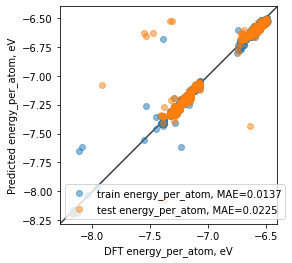

In [16]:
fig, ax = plt.subplots()
for name, data in (("train", train), ("test", test)):
  prediction_column = f"predicted_{config.target}"
  data.loc[:, prediction_column] = model.predict_structures(data.defect_representation)
  ax.scatter(data.loc[:, config.target], data.loc[:, prediction_column],
             label=f"{name} {config.target}, MAE="
             f"{np.mean(np.abs(data.loc[:, config.target]-data.loc[:, prediction_column])):.4f}",
             alpha=0.5)
ax.set_xlabel(f"DFT {config.target}, eV")
ax.set_ylabel(f"Predicted {config.target}, eV")
ax.legend()

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims);